# **Helmholtz PDE example : cas (d)**

## *Discussion sur les formulations*
Type guide d'onde avec : $\Omega = [-L, L] \times [-h, h]$

Formulation sur le site du projet (mise à jour):
\begin{align*}
& -\Delta \varphi(x) - \omega^2 \, \varphi(x) = f(x) \quad \text{in} \enspace \Omega\\
& \varphi = 0 \quad \text{on} \enspace \{ x = \pm L \} \\
& \partial_n \varphi - ik \varphi = 0 \quad \text{on} \enspace \{ y = \pm h \}\\
\end{align*}

Condition de Robin: Cette condition est plus générale que la condition de Neumann et permet de modéliser des pertes d'énergie à la frontière. <br>
Le paramètre k contrôle le degré de perte:<br>
- k=0 correspond à la condition de Neumann pure (pas de perte).<br>
- k>0 correspond à des pertes d'énergie (absorption).<br>
- k<0 correspond à un gain d'énergie (amplification).<br>

<!-- Exemples de sources:  -->
<!-- - 1) Considérons une fonction source de la forme $f(x,y)=sin(kx)sin(ly)$. <br>
    ==> (A VERIFIER ! (gemini) ) En utilisant la méthode de séparation des variables, on trouve:
    $φ(x,y)=∑\_n∑\_m ​A_{mn}.cos(kx)cos(ly).e^{−β_{mn}z} $
    où
    $\partial_n \varphi - ik\varphi = 0$ on  $\partial \Omega$ ==> $\frac{l}{h} = tan(kh)$ <br>

    TO BE CORRECTED -->

<br>

## Discussion sur la formulation la dernière fois:
- Dirichlet & Rubin <br>
$\rightarrow$ Partage des conditions aux limites (Dirichlet et Rubin) sur les 4 frontières (2 et 2) <br>
$\rightarrow$ **Je dois mettre à jour la boundary_loss**...

## General imports

In [1]:
from PIL import Image
import os
from collections import namedtuple
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import grad
import torch.nn.init as init

## Ma tentative

### Mesh & Collocation points

In [2]:
def generate_uniform_mesh(L, h, Nx, Ny):
    x_points = np.linspace(-L, L, Nx)
    y_points = np.linspace(-h, h, Ny)
    mesh_points = np.array(np.meshgrid(x_points, y_points)).T.reshape(-1, 2)
    return mesh_points

# Parameters
L = 1.0
h = 3.0
Nx = 30
Ny = 90

# Generate uniform mesh
collocation_points = generate_uniform_mesh(L, h, Nx, Ny)
# print("Collocation points:", collocation_points)
print("shape of the mesh:", collocation_points.shape)

# Calculate the number of colocation points
number_of_collocation_points = collocation_points.shape[0]
print("Number of colocation points:", number_of_collocation_points)

import torch
# Extract x and y coordinates from collocation_points
x_points = collocation_points[:, 0]
y_points = collocation_points[:, 1]
# Determine the boundary indices
# boundary_indices = torch.arange(number_of_colocation_points)[
#     (x_points == -L) | (x_points == L) | (y_points == -h) | (y_points == h)
# ]
boundary_indices = torch.arange(number_of_collocation_points)[
    np.isclose(x_points, -L, atol=1e-5) |
    np.isclose(x_points, L, atol=1e-5) |
    np.isclose(y_points, -h, atol=1e-5) |
    np.isclose(y_points, h, atol=1e-5) ]

boundary_indices_rubin = torch.arange(number_of_collocation_points)[
    np.isclose(y_points, -h, atol=1e-5) |
    np.isclose(y_points, h, atol=1e-5) ]

boundary_indices_dirichlet = torch.arange(number_of_collocation_points)[
    np.isclose(x_points, -L, atol=1e-5) |
    np.isclose(x_points, L, atol=1e-5) ]

# print("Coloc points:\n", collocation_points)
print("Boundary indices:", len(boundary_indices))   # OK
print("Boundary indices (for Dirichlet):", len(boundary_indices_dirichlet))
print("Boundary indices (for Rubin):", len(boundary_indices_rubin))

shape of the mesh: (2700, 2)
Number of colocation points: 2700
Boundary indices: 236
Boundary indices (for Dirichlet): 180
Boundary indices (for Rubin): 60


### NN Architechture + Loss computation;<br>
$\rightarrow$ Possibility : Forcing the Dirichlet boundary conditions by modifying the forward(). <br>
Can we do s.t like this for the Rubin Condition ?

**I figured out that laplacians are null which isn't the case for gradients. So I printed Debugging Messages and tried to modify laplacian computation but I haven't yet succeeded.**

In [3]:

# Define the MLP architecture
class ComplexMLP(nn.Module):

    # def __init__(self, input_dim, hidden_dim, output_dim):
    #     super(ComplexMLP, self).__init__()
    #     self.layers = nn.Sequential(
    #         nn.Linear(input_dim, hidden_dim//2),
    #         nn.tanh(),
    #         nn.Linear(hidden_dim//2, output_dim),
    #         )
    def __init__(self, input_dim, hidden_dim, output_dim):    #test with CELU and other activations (tanh > relu pour le moment)
        super(ComplexMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, output_dim),
        )

        # Initialize weights using He initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight)

    # def reset_parameters(self):   #méthode d'initialisation adaptée aux ReLU
    #     for layer in self.layers:
    #         if isinstance(layer, nn.Linear):
    #             init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='tanh')
    #             if layer.bias is not None:
    #                 init.constant_(layer.bias, 0)

    def forward(self, x):
        out = x
        for layer in self.layers[:-1]:
            out = layer(out)
            out = torch.sin(out)
        return self.layers[-1](out)

In [4]:
def complex_norm(input_tensor):  #renvoie un tenseur de même taille contenant les carrés des modules de chaque coeff
    real_part = input_tensor.real
    imag_part = input_tensor.imag
    modulus_squared = real_part ** 2 + imag_part ** 2
    return modulus_squared

In [16]:
# Define the loss function incorporating the Helmholtz equation and boundary conditions

def physics_loss(model, source_tensor, X, true_boundary_data, boundary_indices_rubin, boundary_indices_dirichlet, k, Coef = 1e-1, Coef2 = 1):
    # Compute predictions for all points
    predictions = model(X)     # (N_coloc_points, 2)
    x = X[:,0].unsqueeze(1)  # make it a column vector
    y = X[:,1].unsqueeze(1)

    # Extract real and imaginary parts pf predictions
    u_real, u_imag = torch.chunk(predictions, 2, dim=1)
     ## u_real, u_imag = torch.chunk(sol_exacte ,2, dim=1)   ##A faire

    # Compute first derivatives w.r.t. each component of X
    grad_u_real = grad(u_real, X, grad_outputs=torch.ones_like(u_real), create_graph=True)[0]
    grad_u_imag = grad(u_imag, X, grad_outputs=torch.ones_like(u_imag), create_graph=True)[0]

    # Extract components of gradients
    dudx, dudy = grad_u_real[:, 0], grad_u_real[:, 1]
    dvdx, dvdy = grad_u_imag[:, 0], grad_u_imag[:, 1]

    # Compute second derivatives for the Laplacian
    dud2x = grad(dudx, X, grad_outputs=torch.ones_like(dudx), create_graph=True)[0][:, 0]
    dud2y = grad(dudy, X, grad_outputs=torch.ones_like(dudy), create_graph=True)[0][:, 1]
    dvd2x = grad(dvdx, X, grad_outputs=torch.ones_like(dvdx), create_graph=True)[0][:, 0]
    dvd2y = grad(dvdy, X, grad_outputs=torch.ones_like(dvdy), create_graph=True)[0][:, 1]

    # Calculate the complex-valued Laplacian
    laplacian_u = dud2x + dud2y
    laplacian_v = dvd2x + dvd2y
    laplacian = laplacian_u + 1j * laplacian_v

    # Calculate the residual of the Helmholtz equation
    # residual = torch.norm( laplacian_u_real + 1j*laplacian_u_imag + (k**2) * (u_real + 1j*u_imag) + source_values)    # A speed of light c = 1  (?)
    residual = complex_norm(laplacian.reshape(-1,1) + (k**2) * (u_real + 1j*u_imag) + source_tensor.reshape(-1,1))
    residual_loss = torch.mean(residual)     # A CALCULER A LA MAIN


    if np.random.rand()<0.0001:
      print("----------Start Debugging Message----------")
      print("Grad_u_real =", grad_u_real, grad_u_real.shape)
      print("Grad_u_imag =", grad_u_imag, grad_u_imag.shape)
      print("laplacian =", laplacian, " ; of shape:",laplacian.shape)
      print("Residual_loss =", residual_loss.item())
      print("----------End Debugging Message----------")

    # Compute normal derivatives based on boundary direction (complex valued)
    # normal_derivatives_x = (dudx * torch.isclose(x[:, 0], -L).float() - dudx * torch.isclose(x[:, 0], L).float()) + 1j * (dvdx * torch.isclose(x[:, 0], -L).float() - dvdx * torch.isclose(x[:, 0], L).float())
    # normal_derivatives_y = (dudy * torch.isclose(x[:, 1], -h).float() - dudy * torch.isclose(x[:, 1], h).float()) + 1j * (dvdy * torch.isclose(x[:, 1], -h).float() - dvdy * torch.isclose(x[:, 1], h).float())

    normal_derivatives_y = (-dudy.reshape(-1,1) * (y == -h) + dudy.reshape(-1,1) * (y == h)) + 1j*(-dvdy.reshape(-1,1) * (y == -h) + dvdy.reshape(-1,1) * (y == h))  #normale sortante
    normal_derivatives = normal_derivatives_y #+ normal_derivatives_x
    coef_robin = -1j * (y == -h) + 1j * (y == h)
    ### A CORRIGER !!
    # Extract predictions for boundary points
    boundary_predictions_D = predictions[boundary_indices_dirichlet, 0]+ 1j*predictions[boundary_indices_dirichlet, 1]   # (Nbr_of_Dirichlet_bound_points, 1) of complex predictions
    # boundary_predictions_R = predictions[boundary_indices_rubin, 0]+ 1j*predictions[boundary_indices_rubin, 1]           # (Nbr_of_Rubin_bound_points, 1) of complex predictions

    # Enforce boundary conditions [to check]
    boundary_loss_1 = torch.mean( complex_norm(boundary_predictions_D - 0) )    # Mean squared error [Dirichlet Condition]      (c'était: - true_boundary_data[boundary_indices] au lieu de:  -0 -> ça change qlq chose ?)
    u, v = u_real, u_imag
    boundary_loss_2 = torch.mean( complex_norm(normal_derivatives[boundary_indices_rubin] + coef_robin[boundary_indices_rubin] *k*(u[boundary_indices_rubin] + 1j*v[boundary_indices_rubin])) )        #[Rubin]  IL FAUT JUSTE LES POINTS AUX BORDS


    # Total loss
    total_loss = Coef*residual_loss + boundary_loss_1 + 10 * boundary_loss_2                  # Loss_residuelle + loss_boundary_1 + loss_boundary_2
    return residual_loss, boundary_loss_1, boundary_loss_2, total_loss


In [17]:
def exact_function(X):
    x_points = X[:,0].unsqueeze(1)  # make it a column vector
    y_points = X[:,1].unsqueeze(1)
    u = torch.sin(np.pi * x_points / L) * torch.exp(-1j * k * y_points)
    return torch.concat([u.real,u.imag],axis)


In [18]:
#  k*j*phi = j*k*(u + 1j*v) = -k*v + k*j*u
# dphi/dn = du/dn + 1j*dv/dn
# dphi/dn - 1j*k*phi  = ( du/dn - k*v ) + 1j( dv/dn + k*u )

In [19]:
#test cell
print(1j*torch.tensor([1,-3,5])+2)
torch.mean(torch.norm(1j*torch.tensor([1,-3,5])+2))

tensor([2.+1.j, 2.-3.j, 2.+5.j])


tensor(6.8557)

In [20]:
# Move the data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
## CREATING THE SOURCE
k= 1
k_squared = k**2

x_points = torch.tensor(collocation_points[:, 0])
y_points = torch.tensor(collocation_points[:, 1])

# Calculate source values at each collocation point
source_values = (np.pi / L)**2 * torch.sin(np.pi * x_points / L) * torch.exp(-1j * k * y_points)

print(source_values.shape)
print(complex_norm(source_values).mean())

print(torch.norm(source_values))
source_values = source_values.to(device)
# RAPPEL :
# y dans [-h,h] en horizental  ;  x entre [-L,L] en vertical    (h=3 et y=1)
#   ---------------------------------
#   ---------------------------------
#   ---------------------------------
#   ---------------------------------
#   ---------------------------------
#   ---------------------------------

cpu
torch.Size([2700])
tensor(47.0811)
tensor(356.5371)


/tmp/ipykernel_2674964/440404584.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_points = torch.tensor(collocation_points[:, 0])
/tmp/ipykernel_2674964/440404584.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_points = torch.tensor(collocation_points[:, 1])


### Predicting the solution

In [21]:
# Define the model
input_dim = 2 #,number_of_colocation_points     #according to the mesh of the set [-L,L].[-h,h] (the number of points) !
hidden_dim = 128  # to adapt
output_dim = 2 #,input_dim    #the model returns a 2D_tensor of two vectors : u_real and u_imag predictions on every colocation point

model = ComplexMLP(input_dim, hidden_dim, output_dim).to(device)
model2 = ComplexMLP(input_dim, hidden_dim, output_dim).to(device)

In [22]:
# for param in model.parameters():
#     nn.init.zeros_(param)

# Generate true boundary data
true_boundary_data = torch.zeros((len(boundary_indices), 2), device=device, requires_grad=True)   # assuming null Dirichlet boundary conditions for both u and derivée_normale(u)
# Reshape collocation_points to match the input shape expected by the model
collocation_points = torch.tensor(collocation_points, dtype=torch.float32, device=device, requires_grad=True)
# collocation_points = collocation_points.unsqueeze(0)  # Add a batch dimension
# collocation_points = collocation_points.expand(1, number_of_colocation_points, 2).reshape(-1, input_dim)
collocation_points = collocation_points.unsqueeze(0)  # Add a batch dimension
collocation_points = collocation_points.expand(-1, number_of_collocation_points, -1).reshape(-1, input_dim)

boundary_indices = boundary_indices.to(device)
boundary_indices = torch.tensor(boundary_indices, device=device, dtype=torch.long)

/tmp/ipykernel_2674964/1086125528.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  collocation_points = torch.tensor(collocation_points, dtype=torch.float32, device=device, requires_grad=True)
/tmp/ipykernel_2674964/1086125528.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boundary_indices = torch.tensor(boundary_indices, device=device, dtype=torch.long)


In [23]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002)
losses = []
losses_resid, losses_bound1, losses_bound2 = [], [], []

k = 1
# Training loop
num_epochs = 2000
Coef = 0.5
decay = 1  #0.92
for epoch in range(num_epochs):
    optimizer.zero_grad()
    resid, bound_error1, bound_error2, loss = physics_loss(model, source_values, collocation_points, true_boundary_data, boundary_indices_rubin, boundary_indices_dirichlet, k, Coef, Coef2=0.2)  #change coef2
    loss.backward()
    optimizer.step()
    losses.append(loss.item())  # Append the current loss to the list
    losses_resid.append(resid.item())
    losses_bound1.append(bound_error1.item())
    losses_bound2.append(bound_error2.item())
#    if epoch==1800:
#        Coef = Coef*0.3
#        print("*********** 1er Changement du Coef residuel, 0.1 --> 0.5x0.3 *************")
#    if epoch==3500:
#        Coef = Coef*0.3
#        print("*********** 2nd Changement du Coef,  0.5x0.3 --> 0.5x0.3^2 *************")
#    if epoch==0 or (epoch+1)%100==0:
#        print(f"Iteration {epoch+1}/{num_epochs}, Loss: {loss.item():.5f}")
#        if epoch>700:
#            Coef *= decay
    if (epoch+1)%500==0 or epoch==0:
      print("Residual LOSS = ", resid.item(), "  ;  Boundary LOSS = ", bound_error1.item()+bound_error2.item() )

    # if epoch%1000:    #tracer la difference avec la sol analytique
    #     diff = torch.sin(np.pi * x_points / L) * torch.exp(-1j * k * y_points) - model()

#Plotting the loss
plt.plot(range(num_epochs), losses, label='Loss pondérée')
plt.gca().set_yscale('log')
plt.plot(range(num_epochs), losses_resid, label='Loss résiduelle')
plt.gca().set_yscale('log')
plt.plot(range(num_epochs), losses_bound1, label='Loss aux bords (Dirichlet)')
plt.gca().set_yscale('log')
plt.plot(range(num_epochs), losses_bound2, label='Loss aux bords (Robin)')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

Residual LOSS =  125.80596160888672   ;  Boundary LOSS =  6.715020060539246
----------Start Debugging Message----------
Grad_u_real = tensor([[ 2.7694,  0.0117],
        [ 2.7628, -0.0557],
        [ 2.7553, -0.1254],
        ...,
        [ 3.0144,  0.0343],
        [ 3.0802,  0.0433],
        [ 3.1388,  0.0481]], grad_fn=<MmBackward0>) torch.Size([2700, 2])
Grad_u_imag = tensor([[-0.4542, -0.1021],
        [-0.6448, -0.0665],
        [-0.8456, -0.0451],
        ...,
        [ 1.0562,  0.1117],
        [ 0.8987,  0.0595],
        [ 0.7353,  0.0063]], grad_fn=<MmBackward0>) torch.Size([2700, 2])
laplacian = tensor([ 0.2743+0.5052j, -0.0788+0.2445j, -0.2495+0.0136j,  ...,
         0.1133+0.0204j,  0.0416+0.3503j, -0.0407+0.8357j],
       grad_fn=<AddBackward0>)  ; of shape: torch.Size([2700])
Residual_loss = 0.02598993107676506
----------End Debugging Message----------
Residual LOSS =  0.006319234147667885   ;  Boundary LOSS =  0.00042479788135096896
Residual LOSS =  0.002246300457045436

KeyboardInterrupt: 

### Plotting the solution:

In [24]:
print(f"For k={k}: \nFinal Residual:", resid.item(), "\nFinal Bound error:", (bound_error1+bound_error2).item())

For k=1: 
Final Residual: 0.0016764105530455709 
Final Bound error: 9.173808939522132e-05


In [25]:
import numpy as np
import matplotlib.pyplot as plt

x_points = collocation_points[:, 0]
y_points = collocation_points[:, 1]

# Reshape x_points and y_points to match the original grid
x_points = x_points.reshape((Nx, Ny))
y_points = y_points.reshape((Nx, Ny))

# Evaluate the model on the collocation points
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(collocation_points, dtype=torch.float32))

# Compute the magnitude of the complex-valued function U
U_real, U_imag = torch.chunk(predictions, 2, dim=1)
U_magnitude = torch.sqrt(U_real**2 + U_imag**2).cpu().numpy()

# Reshape the magnitude to match the shape of the collocation points
# U_magnitude_plot = U_magnitude.reshape((-1, Ny, Nx))
U_magnitude_plot = U_magnitude.reshape((Nx, Ny))

/tmp/ipykernel_2674964/3045439263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = model(torch.tensor(collocation_points, dtype=torch.float32))


In [26]:
X, Y = np.meshgrid(x_points.detach().cpu(), y_points.detach().cpu())

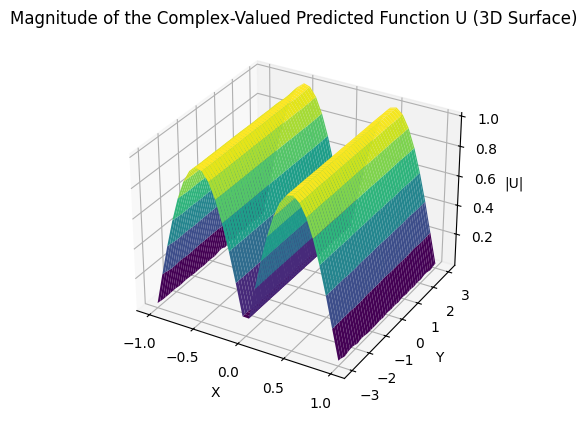

In [27]:
# Plot the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = x_points.detach().cpu(), y_points.detach().cpu()
ax.plot_surface(X, Y, U_magnitude_plot, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('|U|')
ax.set_title('Magnitude of the Complex-Valued Predicted Function U (3D Surface)')
plt.show()

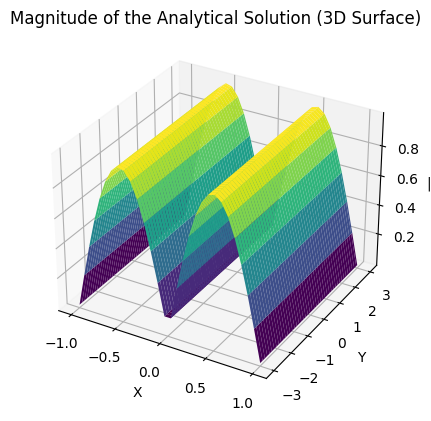

In [66]:
# Reshape the magnitude to match the shape of the collocation points
sol_analytique = torch.sin(np.pi * x_points / L) * torch.exp(-1j * k * y_points)
sol_analytique_plot = torch.abs(sol_analytique).reshape((Nx, Ny))

# Plot the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = x_points.detach().cpu(), y_points.detach().cpu()
ax.plot_surface(X, Y, sol_analytique_plot.cpu().detach().numpy(), cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('|U|')
ax.set_title('Magnitude of the Analytical Solution (3D Surface)')
plt.show()

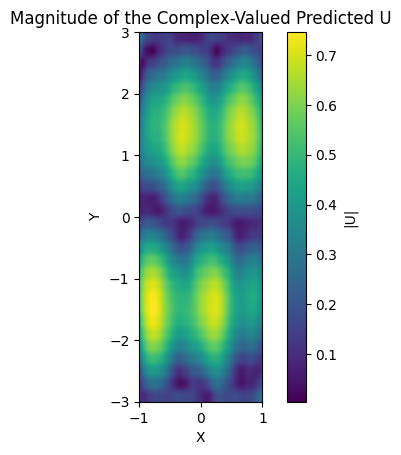

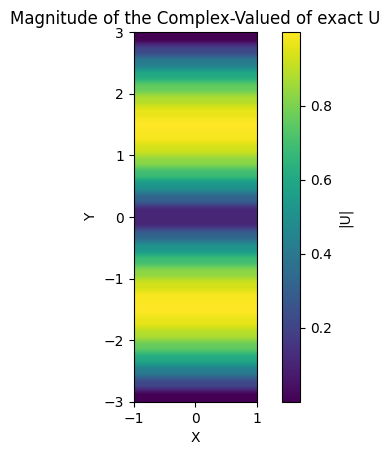

In [67]:
# # Plot the 3D surface plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# X, Y = x_points.detach().cpu(), y_points.detach().cpu()
# ax.plot_surface(X, Y, U_magnitude_plot, cmap='viridis')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('|U|')
# ax.set_title('Magnitude of the Complex-Valued Predicted Function U (3D Surface)')
# plt.show()

fig, ax = plt.subplots()  #plot dans
X, Y = x_points.detach().cpu().numpy(), y_points.detach().cpu().numpy()
im = ax.imshow(U_magnitude_plot, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Magnitude of the Complex-Valued Predicted U')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('|U|')
plt.show()


sol_analytique = torch.sin(np.pi * x_points / L) * torch.exp(-1j * k * y_points)    # ( 30 , 90 ) complex values
real_sol_analytique = torch.real(sol_analytique).view(-1)
imag_sol_analytique = torch.imag(sol_analytique).view(-1)
U_magnitude2 = torch.sqrt(real_sol_analytique**2 + imag_sol_analytique**2).cpu().detach()
U_magnitude_plot_2 = U_magnitude2.reshape((Nx, Ny))

fig, ax = plt.subplots()
X, Y = x_points.detach().cpu().numpy(), y_points.detach().cpu().numpy()
im = ax.imshow(U_magnitude_plot_2, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Magnitude of the Complex-Valued of exact U')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('|U|')
plt.show()



torch.Size([2700])
u_real: torch.Size([2700]) diff shape (2700,)


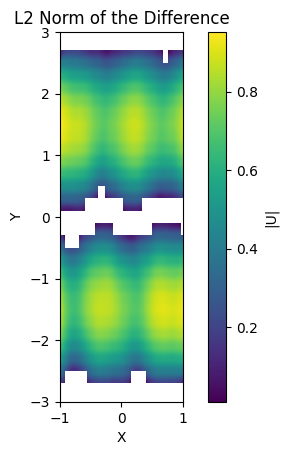

In [68]:
sol_analytique = torch.sin(np.pi * x_points / L) * torch.exp(-1j * k * y_points)    # ( 30 , 90 ) complex values
real_sol_analytique = torch.real(sol_analytique).view(-1)
imag_sol_analytique = torch.imag(sol_analytique).view(-1)
print(real_sol_analytique.shape)
sol_predite = model(collocation_points)    # ( 2700 , 2 )
# Extract real and imaginary parts pf predictions
u_real, u_imag = torch.chunk(sol_predite, 2, dim=1)
u_real, u_imag = u_real.view(-1), u_imag.view(-1)
Difference = torch.sqrt(real_sol_analytique**2 + imag_sol_analytique**2 - u_real**2 - u_imag**2).cpu().detach().numpy()
print("u_real:", u_real.shape, "diff shape", Difference.shape)
# Reshape the magnitude to match the shape of the collocation points
# U_magnitude_plot = U_magnitude.reshape((-1, Ny, Nx))
Difference = Difference.reshape((Nx, Ny))

fig, ax = plt.subplots()
X, Y = x_points.detach().cpu().numpy(), y_points.detach().cpu().numpy()
im = ax.imshow(Difference, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('L2 Norm of the Difference')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('|U|')
plt.show()

####Difference Plot

### Result from last time

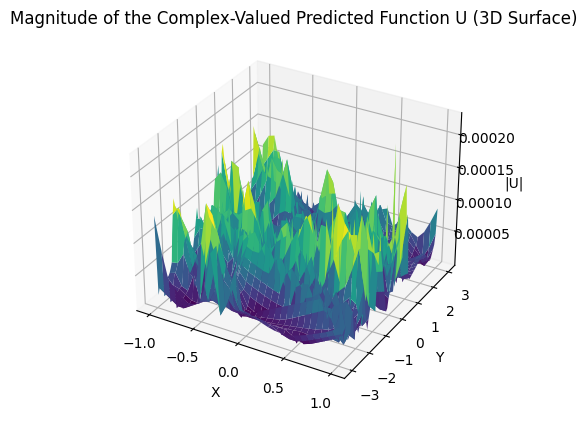

In [ ]:
# Plot the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = x_points.detach().cpu(), y_points.detach().cpu()
ax.plot_surface(X, Y, U_magnitude_plot, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('|U|')
ax.set_title('Magnitude of the Complex-Valued Predicted Function U (3D Surface)')
plt.show()

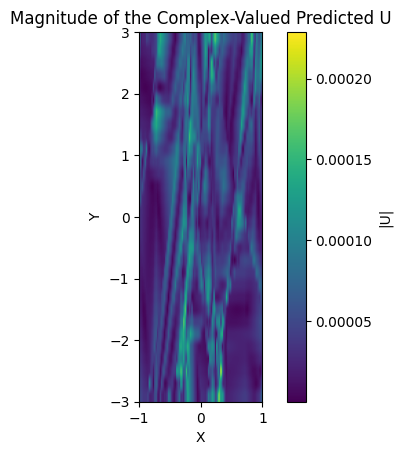

In [ ]:
fig, ax = plt.subplots()
X, Y = x_points.detach().cpu().numpy(), y_points.detach().cpu().numpy()
im = ax.imshow(U_magnitude_plot, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Magnitude of the Complex-Valued Predicted U')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('|U|')
plt.show()

### Plotting Predicted-Exact Error in a 3D figure or a heatmap (Needs Debugging)

## **A second set up** <br>
**[changes in k, in coef decay, in number of points, eventually the architechture]**

In [ ]:
# Define the MLP architecture
class ComplexMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ComplexMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.layers(x)

model2 = ComplexMLP(input_dim, hidden_dim, output_dim).to(device)

In [ ]:
### 2nd SET UP

# Example parameters
L = 3.0
h = 0.5
Nx = 90
Ny = 15

# Generate uniform mesh
collocation_points = generate_uniform_mesh(L, h, Nx, Ny)
# print("Collocation points:", collocation_points)
print("shape of the mesh:", collocation_points.shape)

# Calculate the number of colocation points
number_of_colocation_points = collocation_points.shape[0]
print("Number of colocation points:", number_of_colocation_points)

import torch
# Extract x and y coordinates from collocation_points
x_points = collocation_points[:, 0]
y_points = collocation_points[:, 1]

# Determine the boundary indices
boundary_indices = torch.arange(number_of_colocation_points)[
    (x_points == -L) | (x_points == L) | (y_points == -h) | (y_points == h)
]

shape of the mesh: (1350, 2)
Number of colocation points: 1350


In [ ]:
# Generate true boundary data
true_boundary_data = torch.zeros((len(boundary_indices), 2), device=device, requires_grad=True)   # assuming null Dirichlet boundary conditions for both u and derivée_normale(u)
# Reshape collocation_points to match the input shape expected by the model
collocation_points = torch.tensor(collocation_points, dtype=torch.float32, device=device, requires_grad=True)
# collocation_points = collocation_points.unsqueeze(0)  # Add a batch dimension
# collocation_points = collocation_points.expand(1, number_of_colocation_points, 2).reshape(-1, input_dim)
collocation_points = collocation_points.unsqueeze(0)  # Add a batch dimension
collocation_points = collocation_points.expand(-1, number_of_colocation_points, -1).reshape(-1, input_dim)

boundary_indices = boundary_indices.to(device)

Iteration 1/7500, Loss: 87098.586
Iteration 100/7500, Loss: 58.299
Iteration 200/7500, Loss: 26.853
Iteration 300/7500, Loss: 20.141
Iteration 400/7500, Loss: 11.147
Iteration 500/7500, Loss: 11.000
Residual LOSS =  249936.15625   ;  Boundary LOSS =  8.50064754486084
Iteration 600/7500, Loss: 11.000
Iteration 700/7500, Loss: 11.000
Iteration 800/7500, Loss: 11.000
Iteration 900/7500, Loss: 10.783
Iteration 1000/7500, Loss: 10.546
Residual LOSS =  348859.8125   ;  Boundary LOSS =  7.593564510345459
Iteration 1100/7500, Loss: 10.289
Iteration 1200/7500, Loss: 10.010
Iteration 1300/7500, Loss: 9.707
Iteration 1400/7500, Loss: 9.377
Iteration 1500/7500, Loss: 9.018
Residual LOSS =  803205.625   ;  Boundary LOSS =  4.537825584411621
Iteration 1600/7500, Loss: 8.722
Iteration 1700/7500, Loss: 9.747
Iteration 1800/7500, Loss: 8.835
Iteration 1900/7500, Loss: 7.712
Iteration 2000/7500, Loss: 8.793
Residual LOSS =  469640.84375   ;  Boundary LOSS =  7.066596984863281
Iteration 2100/7500, Loss: 

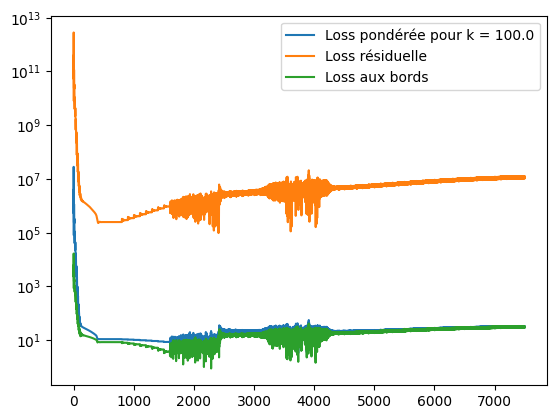

In [ ]:
#MODEL 2 (different k)
k=1e2

# Define optimizer
optimizer = optim.Adam(model2.parameters(), lr=0.005)
losses = []
losses_resid, losses_bound = [], []

# Training loop
num_epochs = 7500
Coef = 1e-5
decay = 0.92
for epoch in range(num_epochs):
    optimizer.zero_grad()
    resid, bound_error, loss = physics_loss(model2, collocation_points, true_boundary_data, boundary_indices, k, Coef)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())  # Append the current loss to the list
    losses_resid.append(resid.item())
    losses_bound.append(bound_error.item())
    if epoch==0 or (epoch+1)%100==0:
        print(f"Iteration {epoch+1}/{num_epochs}, Loss: {loss.item():.3f}")
        if epoch>700:
            Coef *= decay
    if (epoch+1)%500==0:
      print("Residual LOSS = ", resid.item(), "  ;  Boundary LOSS = ", bound_error.item() )


#Plotting the loss
plt.plot(range(num_epochs), losses, label='Loss pondérée pour k = '+str(k))
plt.gca().set_yscale('log')
plt.plot(range(num_epochs), losses_resid, label='Loss résiduelle')
plt.gca().set_yscale('log')
plt.plot(range(num_epochs), losses_bound, label='Loss aux bords')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

<ipython-input-26-a2bb4b5bb1a2>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = model2(torch.tensor(collocation_points, dtype=torch.float32))


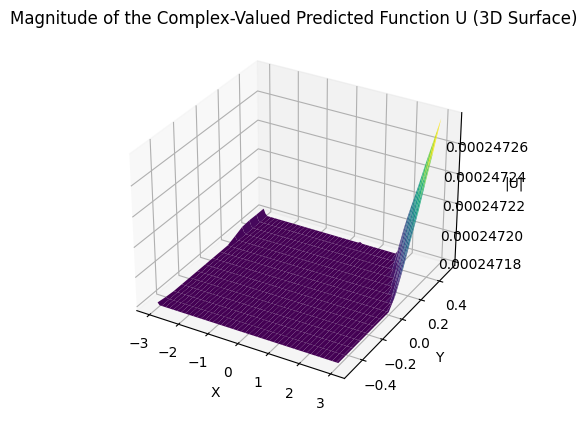

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_points = collocation_points[:, 0]
y_points = collocation_points[:, 1]

# Reshape x_points and y_points to match the original grid
x_points = x_points.reshape((Nx, Ny))
y_points = y_points.reshape((Nx, Ny))

# Evaluate the model on the collocation points
model.eval()
with torch.no_grad():
    predictions = model2(torch.tensor(collocation_points, dtype=torch.float32))

# Compute the magnitude of the complex-valued function U
U_real, U_imag = torch.chunk(predictions, 2, dim=1)
U_magnitude = torch.sqrt(U_real**2 + U_imag**2).cpu().numpy()

# Reshape the magnitude to match the shape of the collocation points
# U_magnitude_plot = U_magnitude.reshape((-1, Ny, Nx))
U_magnitude_plot = U_magnitude.reshape((Nx, Ny))


# Plot the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = x_points.detach().cpu(), y_points.detach().cpu()
ax.plot_surface(X, Y, U_magnitude_plot, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('|U|')
ax.set_title('Magnitude of the Complex-Valued Predicted Function U (3D Surface)')
plt.show()

L'article https://core.ac.uk/download/pdf/82014892.pdf traite le cas (d) en 1D avec des éléments finis (pourrait être intéressant)

# Eventuelle exploitation du code d'Antoine (Class Helmholtz_d)... [not done yet]

In [ ]:
def save_gif_pil(outfile, files, fps=5, loop=0):
    """Helper function for saving GIFs"""
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:],
                 save_all=True, duration=int(1000 / fps), loop=loop)

In [ ]:
class CauchyProblem(ABC):
    @abstractmethod
    def reference_solution(self, x):
        pass

    @abstractmethod
    def residual(self, ddy, dy, y):
        pass

    @abstractmethod
    def cauchy_conditions(self, dy, y):
        pass


class Oscillator(CauchyProblem):
    """
    Equation
        m y''(x) + mu y'(x) + k y(x) = 0,  x in (0, 1)
    Initial condition
        y(0) = 1
        y'(0) = 1
    Here
        - dumping = mu / 2m
        - pulsation = sqrt(k/m)
    """
    def __init__(self, dumping, pulsation):
        assert dumping < pulsation
        self.d = dumping
        self.w0 = pulsation
        self.y0 = 1.0
        self.dy0 = 0.0

    def reference_solution(self, x):
        """Defines the analytical solution to the 1D underdamped harmonic
        oscillator problem.
        Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
        """
        w = np.sqrt(self.w0 ** 2 - self.d ** 2)
        phi = np.arctan(-self.d / w)
        a = 1 / (2 * np.cos(phi))
        cos = torch.cos(phi + w * x)
        # sin = torch.sin(phi + w * x)
        exp = torch.exp(-self.d * x)
        return exp * 2 * a * cos

    def residual(self, ddy, dy, y):
        mu = 2 * self.d
        k = self.w0 ** 2
        return ddy + mu * dy + k * y

    def cauchy_conditions(self, dy, y):
        return namedtuple("CauchyCond", ["y0", "dy0"])(y[0] - self.y0,
                                                       dy[0] - self.dy0)


class Helmholtz_d(CauchyProblem):
    """
    Equation
    Helmhotlz type guide d'onde (cas d)
    """
    def __init__(self, pulsation, L, h):
        self.w0 = pulsation
        self.L = L
        self.h = h
        self.y0 = 0.0


    def residual(self, ddy, dy, y):
        mu = 2 * self.d
        k = self.w0 ** 2
        return ddy + mu * dy + k * y

    def cauchy_conditions(self, dy, y):
        return namedtuple("CauchyCond", ["y0", "dy0"])(y[0] - self.y0,
                                                       dy[0] - self.dy0)

In [ ]:
class SinActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)


class FullyConnectedNetwork(nn.Module):
    """Defines a connected network"""

    def __init__(self, input_dim, output_dim, hidden_dim, nb_layers):
        super().__init__()
        activation = nn.Tanh
        # activations = [nn.Tanh for _ in range(nb_layers - 1)]
        activations = [SinActivation for _ in range(nb_layers - 1)]
        activations[-1] = SinActivation
        self.fcs = nn.Sequential(nn.Linear(input_dim, hidden_dim), activation())
        self.fch = nn.Sequential(
            *[nn.Sequential(nn.Linear(hidden_dim, hidden_dim), act())
              for act in activations])
        self.fce = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
def plot_result(x_exact, y_exact, xp, yh, epoch, file_name):
    """Pretty plot training results"""
    plt.figure(figsize=(8, 4))
    plt.plot(x_exact, y_exact, color="grey", linewidth=2,
             alpha=0.8,
             label="Exact solution")
    plt.plot(x_exact, yh, color="tab:blue", linewidth=4, alpha=0.8,
             label="Neural network prediction")
    plt.scatter(xp, -0 * torch.ones_like(xp), s=60, color="tab:green",
                alpha=0.4,
                label='Physics loss training locations')
    legend = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(legend.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, "Training step: %i" % (epoch + 1), fontsize="xx-large",
             color="k")
    plt.axis("off")
    plt.savefig(file_name, bbox_inches='tight',
                pad_inches=0.1, dpi=100, facecolor="white")


def plot_losses(losses):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.subplots(2, 2)
    epoch_list = range(len(losses.residual))
    ax[0][0].semilogy(epoch_list, losses.total,
                      color="black",
                      label="Total loss")
    ax[0][1].semilogy(epoch_list, losses.residual,
                      color="red",
                      label="loss residual")
    ax[1][0].semilogy(epoch_list, losses.init_value,
                      color="green",
                      label="loss (y[0] - 1)**2")
    ax[1][1].semilogy(epoch_list, losses.init_derivative,
                      color="green",
                      label="loss dy/dx[0]**2")
    [(a.grid(), a.legend()) for aa in ax for a in aa]
    fig.savefig("loss_convergence")

In [ ]:
class SavedLosses:
    def __init__(self):
        self.total = []
        self.residual = []
        self.init_value = []
        self.init_derivative = []

    def save(self, total, residual, init_value, init_derivative):
        self.total.append(total)
        self.residual.append(residual)
        self.init_value.append(init_value)
        self.init_derivative.append(init_derivative)

In [ ]:
def train_pinns(cauchy_problem: CauchyProblem):
    plots_dir = "./plots"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    # get the analytical solution over the full domain
    n_pts = 500
    x_exact = torch.linspace(0, 1, n_pts).view(-1, 1).requires_grad_(True)
    y_exact = cauchy_problem.reference_solution(x_exact).view(-1, 1)

    # sample locations over the problem domain
    n_col_pts = 30
    collocation_pts = torch.linspace(0, 1,
                                     n_col_pts,
                                     requires_grad=True).view(-1, 1)

    model = FullyConnectedNetwork(input_dim=1,
                                  output_dim=1,
                                  hidden_dim=32,
                                  nb_layers=3)

    coef_loss_residual = 5*1e-5   #Original value = 1e-5
    coef_loss_y0 = 1e1
    coef_loss_dy0 = 1e-4

    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    n_epoch = 28_000

    def lr_multiplier(epoch):
        return 1 ** (epoch / n_epoch)

    scheduler = lr_scheduler.LambdaLR(optimizer,
                                      lr_lambda=lr_multiplier)
    files = []
    losses = SavedLosses()
    for epoch in tqdm.tqdm(range(n_epoch)):
        optimizer.zero_grad()
        y = model(collocation_pts)
        # computes dy/dx
        dy = torch.autograd.grad(y, collocation_pts,
                                 torch.ones_like(y),
                                 create_graph=True)[0]

        # computes d^2y/dx^2
        ddy = torch.autograd.grad(dy, collocation_pts,
                                  torch.ones_like(dy),
                                  create_graph=True)[0]

        # computes the residual of the 1D harmonic oscillator differential
        residual = cauchy_problem.residual(ddy, dy, y)
        loss_residual = torch.mean(residual ** 2)
        cauchy_cond = cauchy_problem.cauchy_conditions(dy, y)
        loss_y0, loss_dy0 = cauchy_cond.y0 ** 2, cauchy_cond.dy0 ** 2

        # backpropagate joint loss
        loss = (coef_loss_residual * loss_residual
                + coef_loss_y0 * loss_y0
                + coef_loss_dy0 * loss_dy0)

        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.save(total=loss.item(),
                    residual=loss_residual.item(),
                    init_value=loss_y0.item(),
                    init_derivative=loss_dy0.item())

        # plot the result as training progresses
        if (epoch + 1) % 500 == 0:
            print("")
            print(f"* Learning rate = {optimizer.param_groups[0]['lr']:.2e}")
            print(f"* Losses")
            print(f"    - Residual loss     = "
                  f"{loss_residual.item():.2e}")
            print(f"    - Initial cond loss = "
                  f"{loss_y0.item():.2e}   {loss_dy0.item():.2e}")
            print(f"=> Total weighted loss = {loss.item():.2e}")
            yh = model(x_exact).detach()
            xp = collocation_pts.detach()

            file_name = f"{plots_dir}/pinn_{epoch + 1:8d}.png"
            plot_result(x_exact=x_exact.detach().numpy(),
                        y_exact=y_exact.detach().numpy(),
                        xp=xp, yh=yh, epoch=epoch,
                        file_name=file_name)
            files.append(file_name)

    save_gif_pil("pinn.gif", files, fps=20, loop=0)
    plot_losses(losses)

In [ ]:
if __name__ == '__main__':
    torch.manual_seed(123)
    oscillator = Oscillator(dumping=2, pulsation=20)
    compute_pinn = True
    compute_from_data = False
    if compute_pinn:
        train_pinns(oscillator)
    if compute_from_data:
        train_from_data(oscillator)
    print("done!")